# Inference notebook

In [1]:
import torch
import rasterio
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset, random_split, DataLoader
from PIL import Image
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter
from tqdm.notebook import trange
import random
from torch.optim import SGD
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import Function_lib as lib

### Load one image/sample from the test set

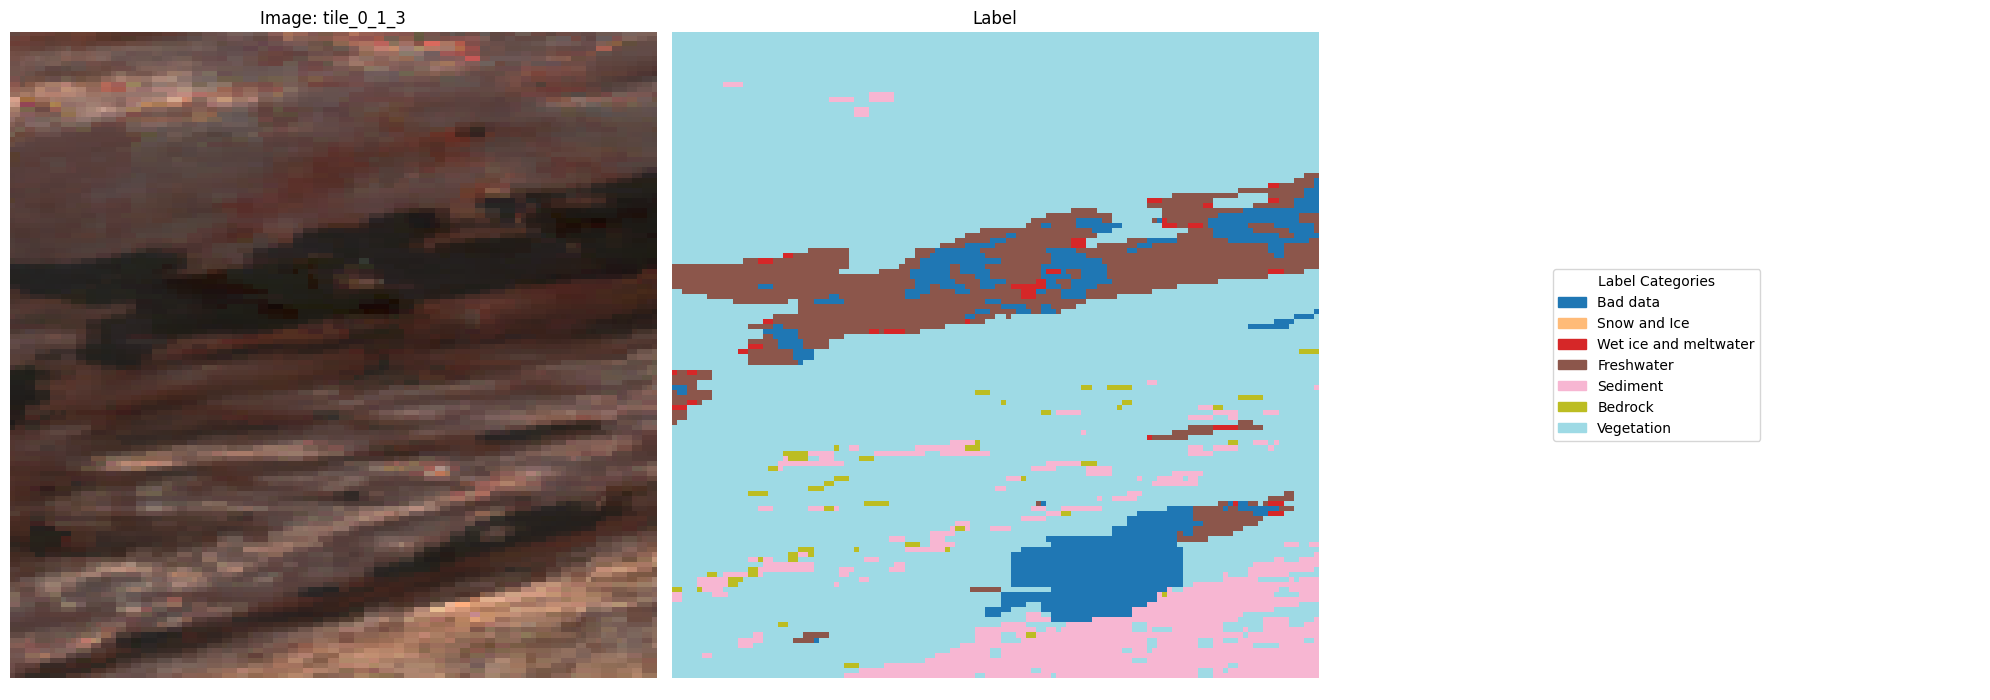

In [2]:
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

dataloader_test = DataLoader(lib.GreenlandData(split='test'), batch_size=1, num_workers=1)
image, label , imgName= iter(dataloader_test).__next__()

fig, axes = plt.subplots(1, 3,figsize=(20, 7) )
axes[0].imshow(image[0])
axes[0].set_title(f'Image: {imgName[0]}')
axes[0].axis('off')

axes[1].imshow(label[0], cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[1].set_title('Label')
axes[1].axis('off')

import matplotlib.patches as mpatches
colors = plt.cm.tab20(np.linspace(0, 1, len(label_names)))
patches = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(len(label_names))]
    
axes[2].legend(handles=patches, loc='center', title="Label Categories")
axes[2].axis('off')

plt.tight_layout()
plt.show()


### Load trained parameters from the best model trained: Pretrained Unet with added features

In [14]:
from segmentation_models_pytorch import Unet
path_to_model = 'cnn_states/pretrainedUnet_features'
model, epoch = lib.load_model(Unet(encoder_name="resnet34", encoder_weights="imagenet",  in_channels=3, classes=7 ), path_to_model, epoch='latest')

/home/zfourati/IPEO_project/IPEO_project2.0/Function_lib.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stateDict = torch.load(open(f'{path_to_model}/{epoch}.pth', 'r

### Run inference on one image from the test set

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
        device = 'cuda'
        
dataloader_test = lib.ReshapeDataLoader(DataLoader(lib.GreenlandData_Unet_features(split='test'), batch_size=1, num_workers=1))
image, label , imgName= iter(dataloader_test).__next__()
model = model.to(device)
with torch.no_grad():
        pred = model(image.to(device))
        # get the label (i.e., the maximum position for each pixel along the class dimension)
        yhat = torch.argmax(pred, dim=1)


## display the predictions for this image

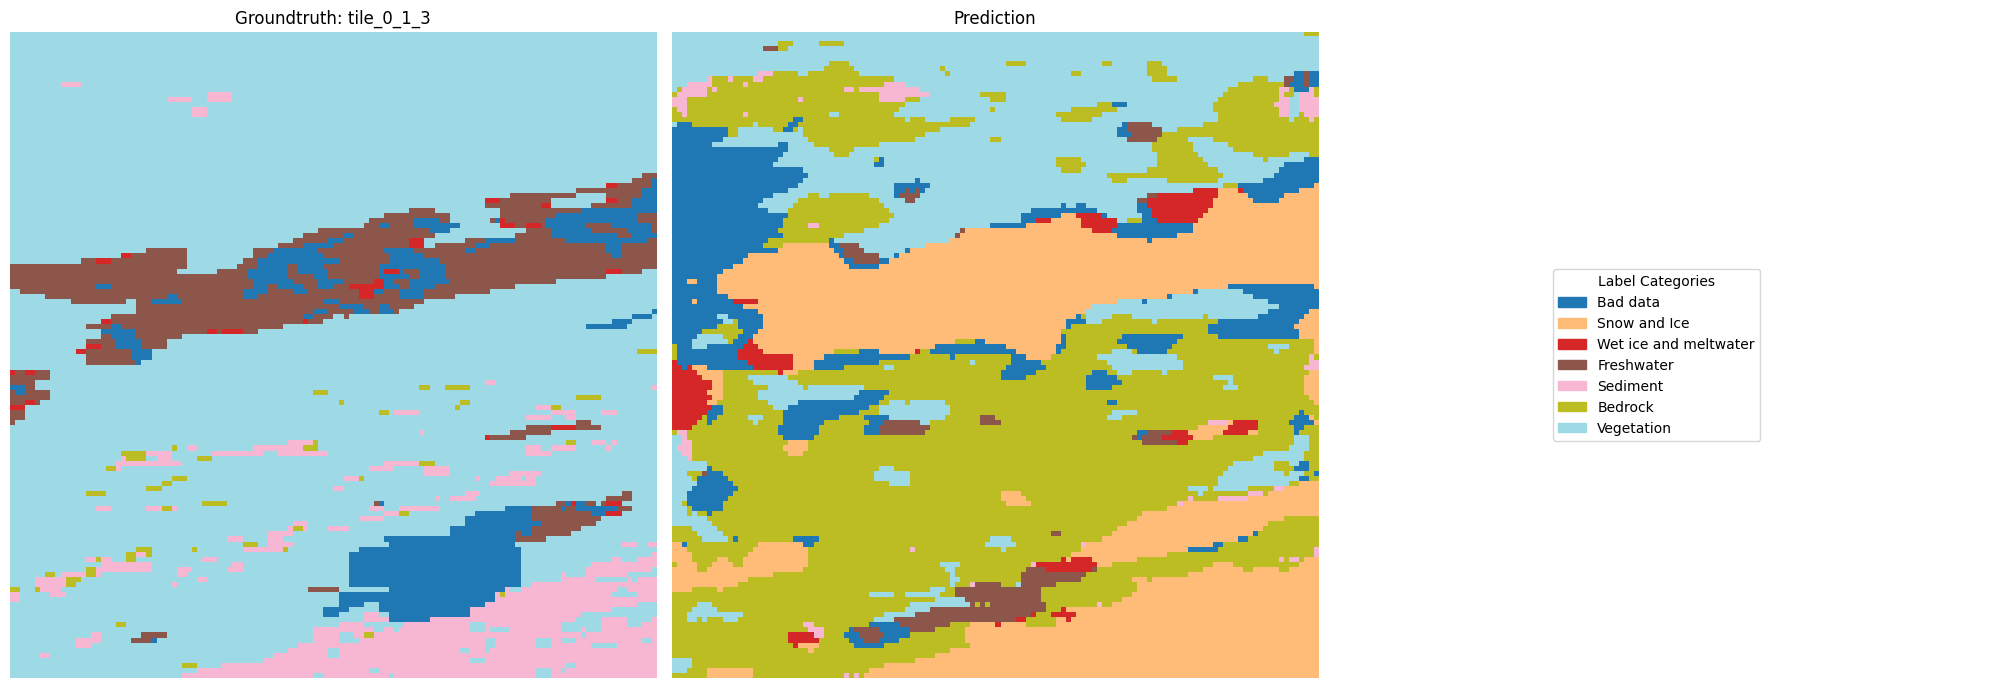

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].imshow(label[0], cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[0].set_title(f'Groundtruth: {imgName[0]}')
axes[0].axis('off')

axes[1].imshow(yhat.squeeze(0).cpu().numpy(), cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[1].set_title('Prediction')
axes[1].axis('off')

import matplotlib.patches as mpatches
colors = plt.cm.tab20(np.linspace(0, 1, len(label_names)))
patches = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(len(label_names))]
axes[2].legend(handles=patches, loc='center', title="Label Categories")
axes[2].axis('off')

plt.tight_layout()
plt.show()